In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import matplotlib.cm as cm
from matplotlib import colormaps
from matplotlib.colors import Normalize


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from scipy.stats import gaussian_kde
import statsmodels.api as sm
from statsmodels.stats import diagnostic

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import FeatureHasher
from statsmodels.stats.outliers_influence import variance_inflation_factor

Wczytywanie danych

In [2]:
database = pd.read_csv('car_prices.csv')
database.shape

(558837, 16)

#Wyczyszczenie danych z pojazdów których ilość jest mniejsza niż 0,01%

In [3]:
# database['make'] = database['make'].str.title()
# models_count_by_make = database.groupby('make')['make'].transform('count')
# database[models_count_by_make >=len(database)*0.0001]
# database.shape

Wyczyszczenie wierszy zawierających wartości N/A w kolumnie 'mmr' oraz 'sellingprice'

In [4]:
# # database.dropna(subset=['mmr','sellingprice'],axis='rows')
# database = database.dropna(subset=['make','mmr','sellingprice'],axis='rows')
# database.shape

Wykres ilości sprzedanych pojazdów wg. marek

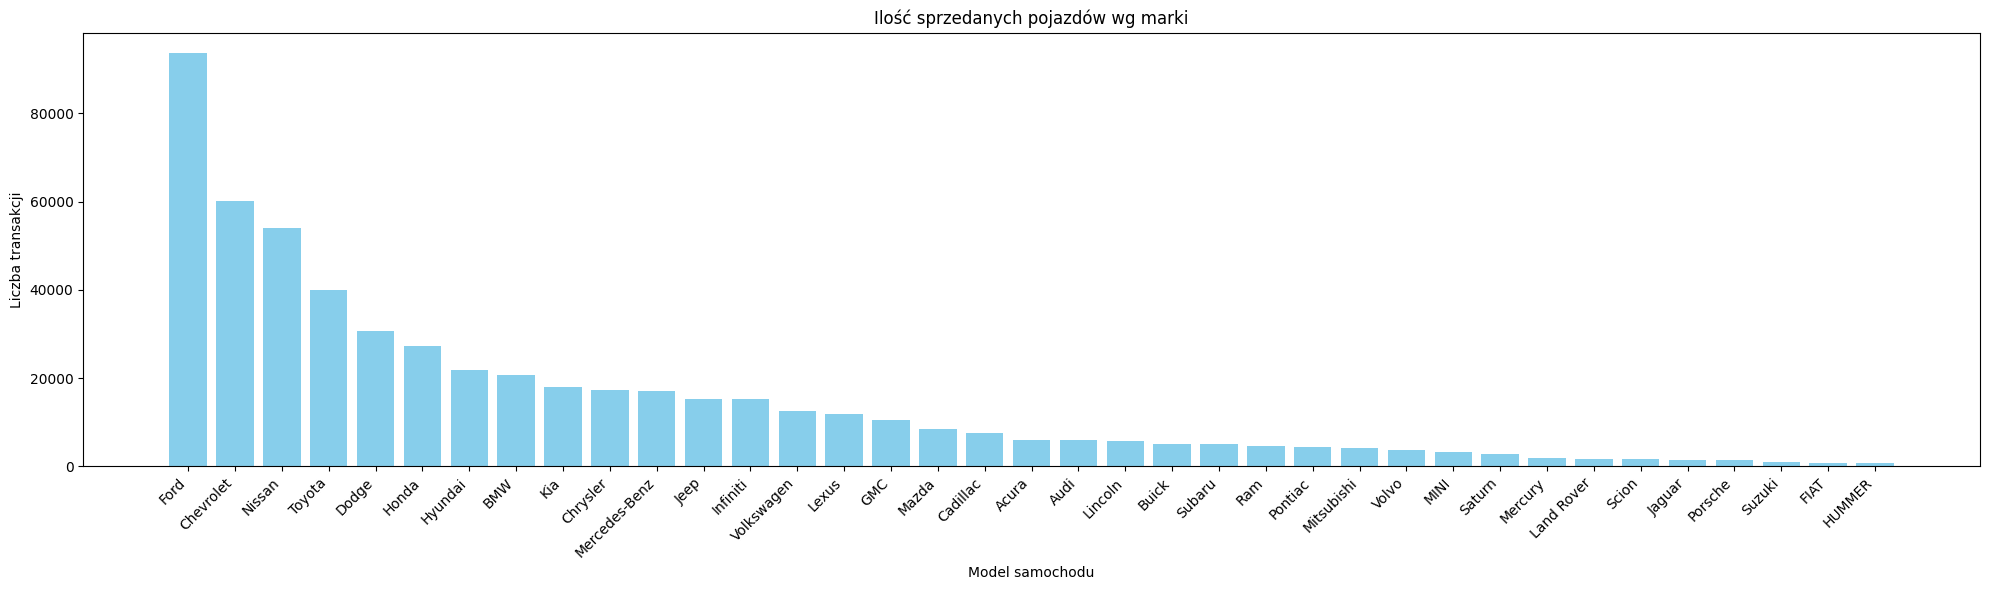

In [5]:
model_car_sum = database['make'].value_counts()
model_car_filtered = model_car_sum[model_car_sum>500]

plt.figure(figsize=(20, 6))
plt.bar(model_car_filtered.index, model_car_filtered.values, color='skyblue')
plt.xlabel('Model samochodu')
plt.ylabel('Liczba transakcji')
plt.title('Ilość sprzedanych pojazdów wg marki')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Średni przebieg pojazdów wg marki

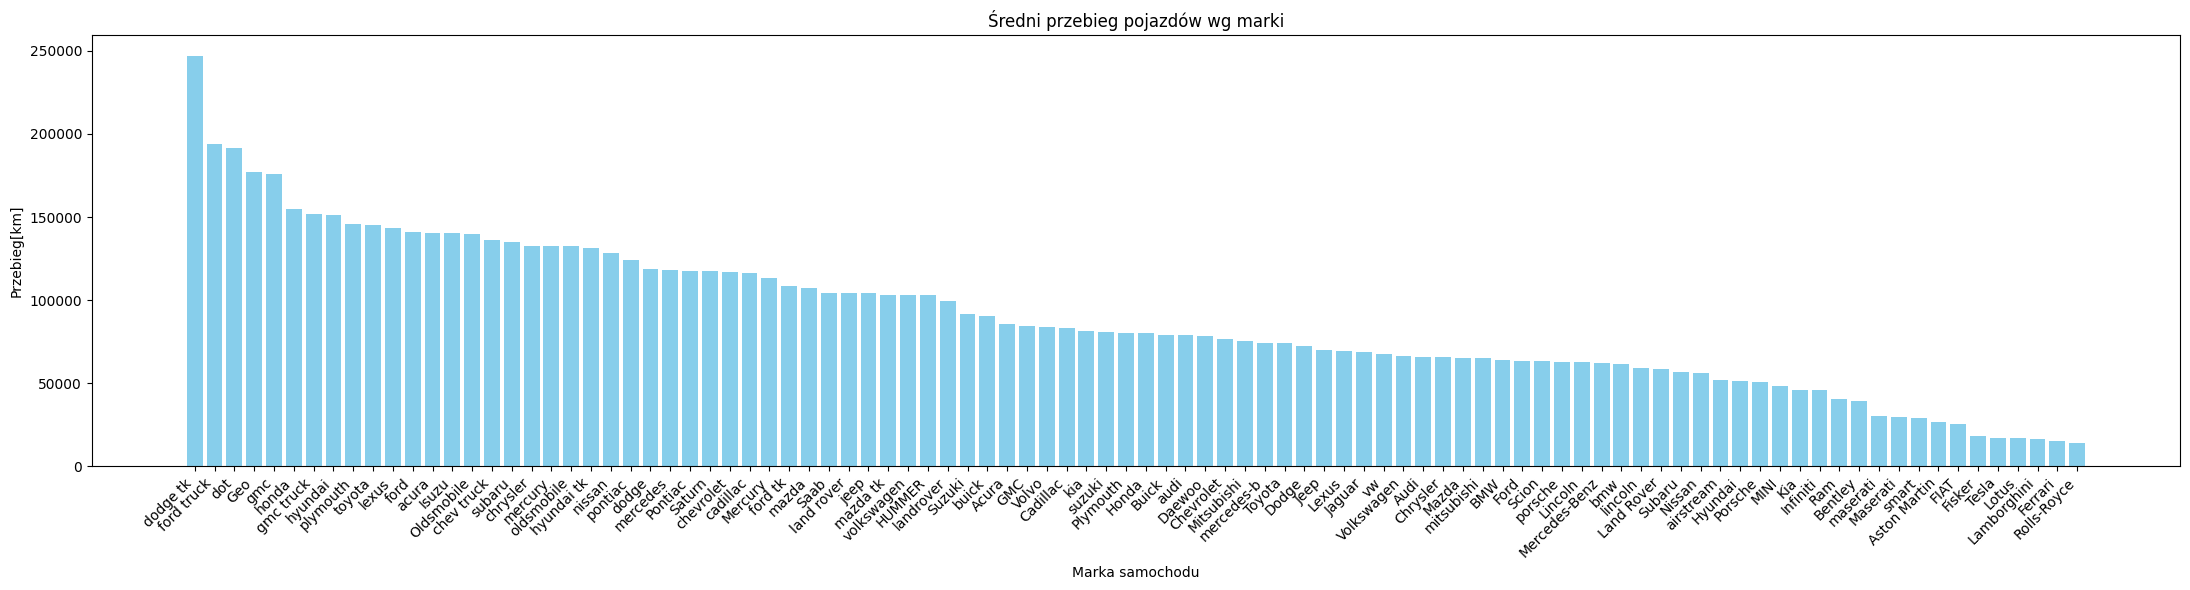

In [6]:
mean_odometer = database.groupby('make')['odometer'].mean()
mean_odometer_sorted = mean_odometer.sort_values(ascending=False)

plt.figure(figsize=(22, 6))
plt.bar(mean_odometer_sorted.index, mean_odometer_sorted.values, color='skyblue')
plt.xlabel('Marka samochodu')
plt.ylabel('Przebieg[km]')
plt.title('Średni przebieg pojazdów wg marki')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


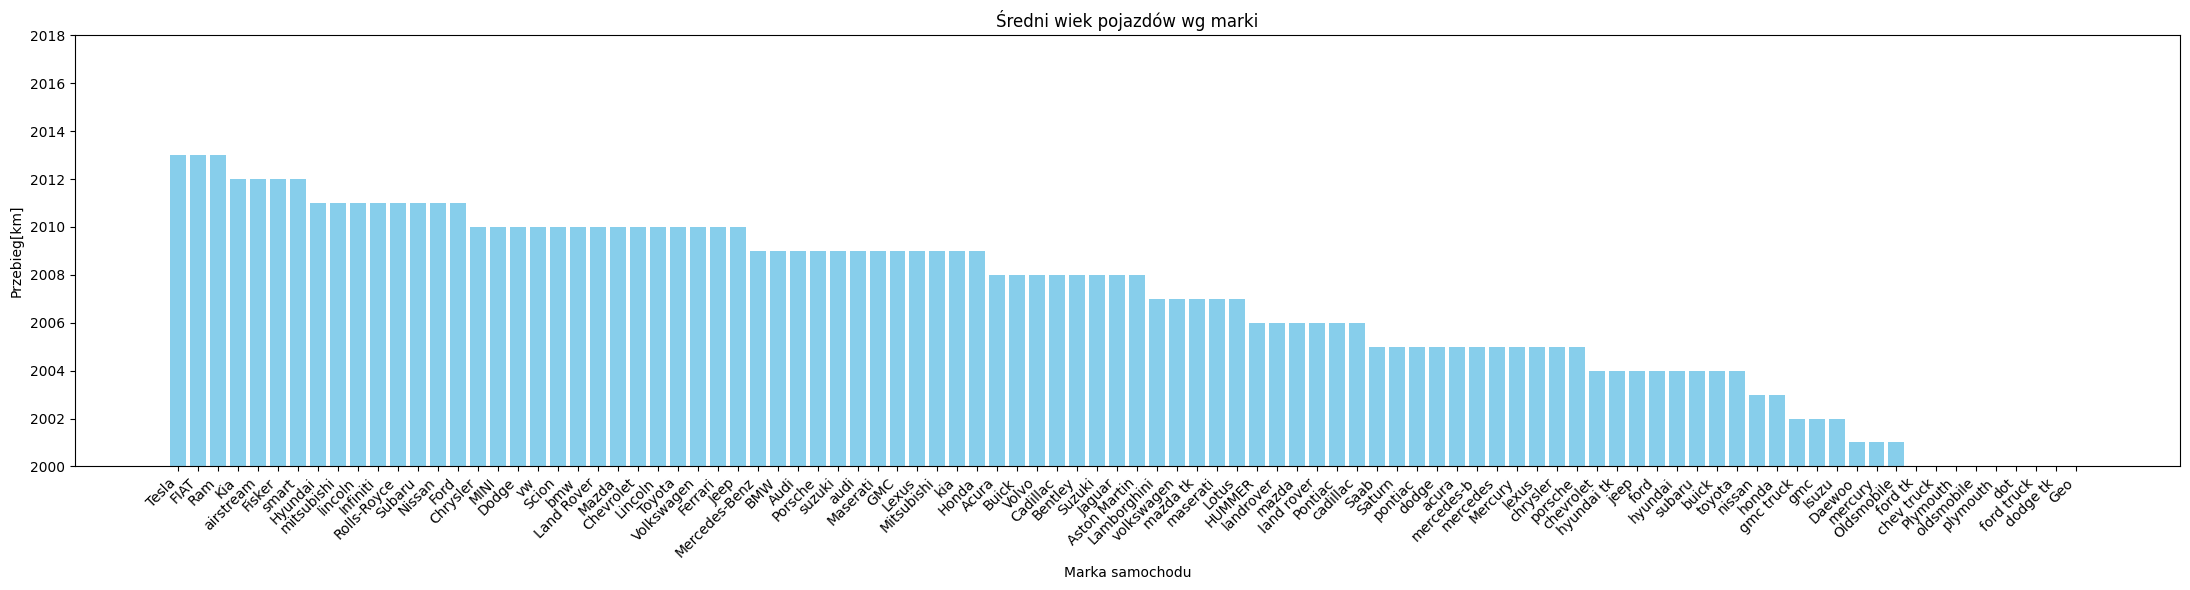

In [7]:

mean_age = database.groupby('make')['year'].mean()
mean_age_sorted = mean_age.sort_values(ascending=False).round().astype(int)


plt.figure(figsize=(22, 6))
plt.bar(mean_age_sorted.index, mean_age_sorted.values, color='skyblue')
plt.xlabel('Marka samochodu')
plt.ylabel('Przebieg[km]')
plt.title('Średni wiek pojazdów wg marki')
plt.xticks(rotation=45, ha='right')
plt.ylim(2000, 2018)
plt.tight_layout()
plt.show()

Średnia cena pojazdu wg marki

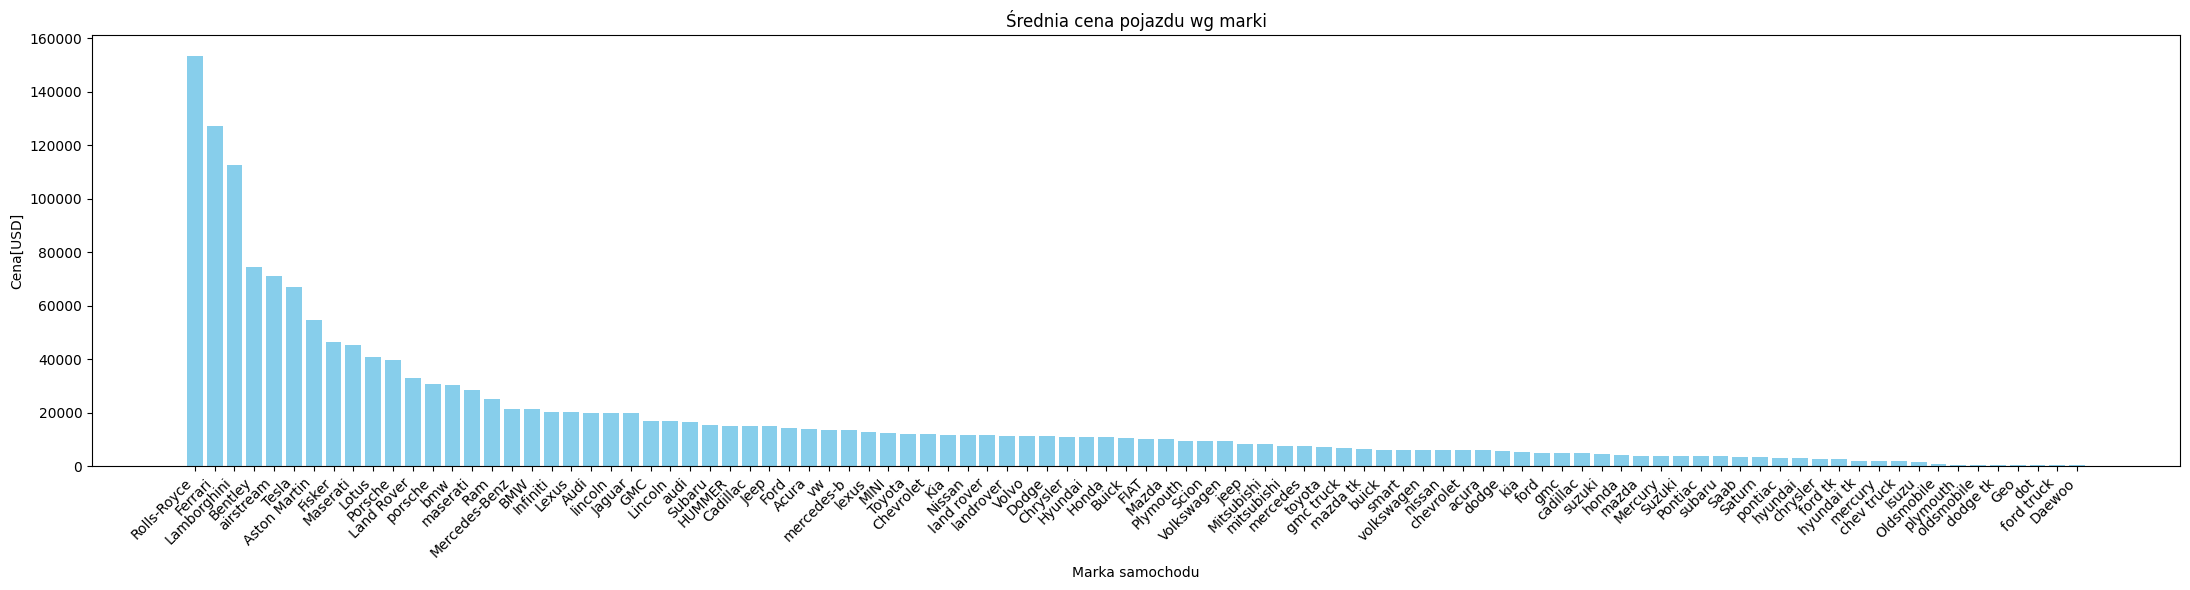

In [8]:
mean_price = database.groupby('make')['sellingprice'].mean()
mean_price_sorted = mean_price.sort_values(ascending=False).round().astype(int)


plt.figure(figsize=(22, 6))
plt.bar(mean_price_sorted.index, mean_price_sorted.values, color='skyblue')
plt.xlabel('Marka samochodu')
plt.ylabel('Cena[USD]')
plt.title('Średnia cena pojazdu wg marki')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

10 najdroższych marek wraz z 5 modelami

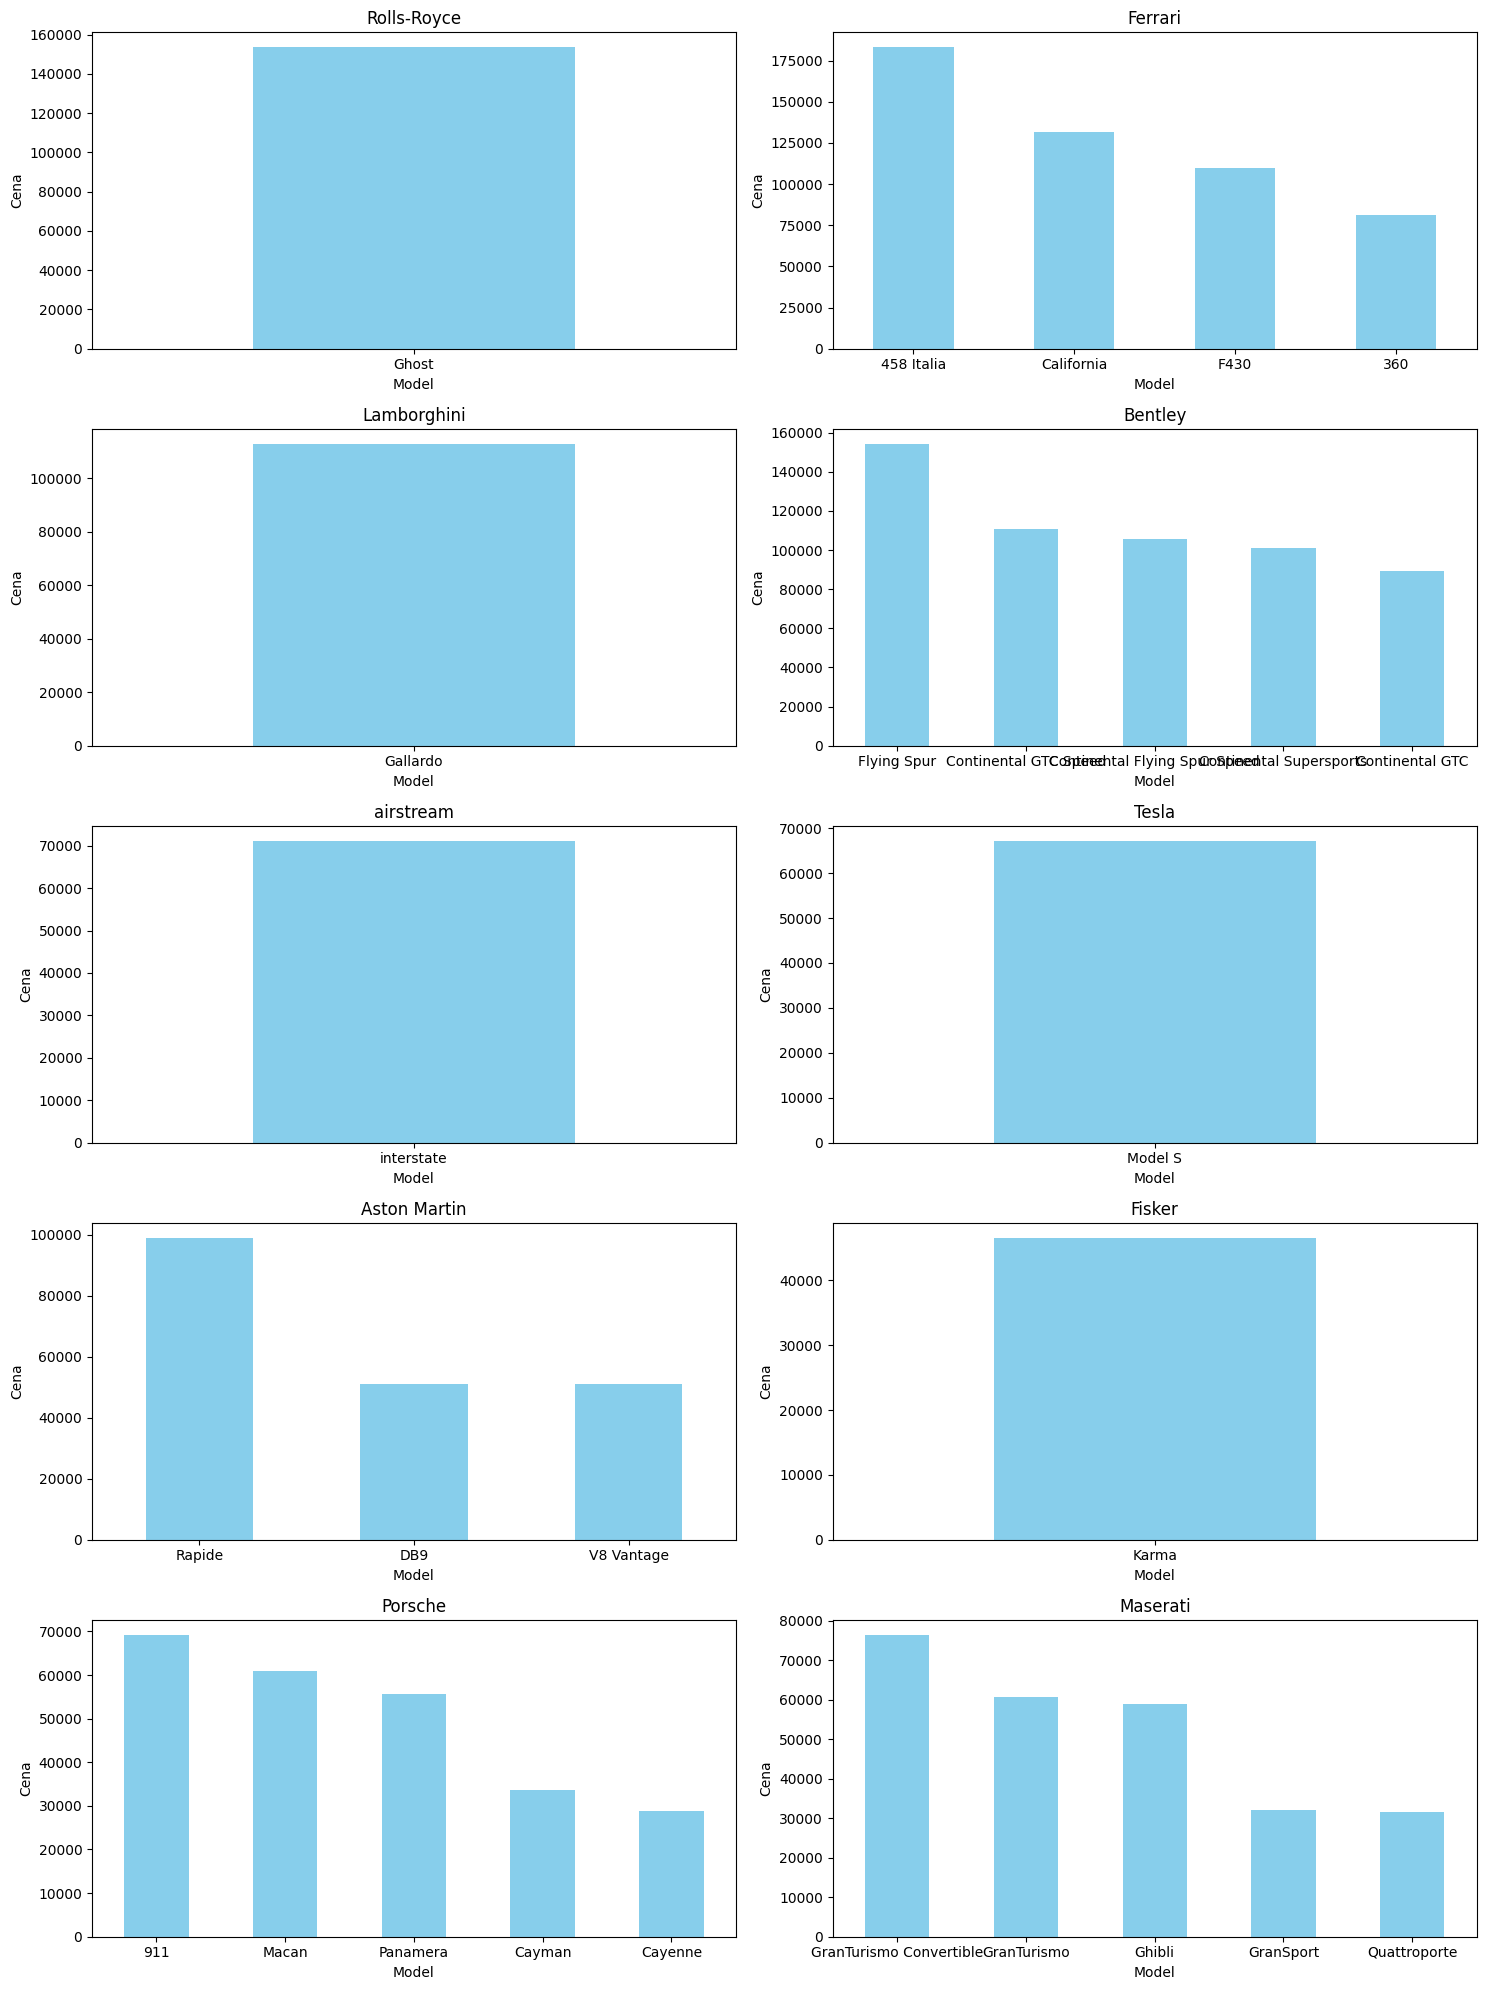

In [9]:
average_prices = database.groupby(['make', 'model'])['sellingprice'].mean()

top_makes = average_prices.groupby('make').mean().nlargest(10)

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 2 * len(top_makes)))

for i, (make, avg_price) in enumerate(top_makes.items()):
    top_models = average_prices.loc[make].nlargest(5)
    
    top_models.plot(kind='bar', ax=axes[i // 2, i % 2], color='skyblue')
    
    axes[i // 2, i % 2].set_title(make)
    axes[i // 2, i % 2].set_ylabel('Cena')
    axes[i // 2, i % 2].set_xlabel('Model')
    axes[i // 2, i % 2].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

Regresja liniowa

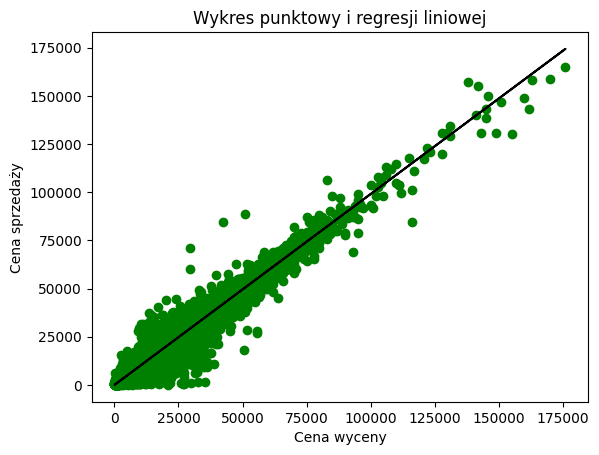

In [10]:
from sklearn.linear_model import LinearRegression

data = database.dropna(axis='rows', subset=['mmr', 'sellingprice', 'make'])

X = data['mmr'].values.reshape(-1,1)
y = data['sellingprice']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state = 1410)

reg = LinearRegression().fit(X_train, y_train)
res = reg.score(X_test, y_test)

y_pred = reg.predict(X_test)
plt.scatter(X_test, y_test, color ='green')
plt.plot(X_test, y_pred, color ='k')
plt.title('Wykres regresji liniowej kwoty wyceny i sprzedaży auta')

plt.xlabel('Cena wyceny')
plt.ylabel('Cena sprzedaży')
 
plt.show()



In [22]:
from sklearn.tree import DecisionTreeRegressor

X = pd.get_dummies(data['make'])
y = data['mmr']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1410)

tree_model = DecisionTreeRegressor(random_state=1410)
tree_model.fit(X_train, y_train)

y_pred = tree_model.predict(X_test)
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
y_test_avg = y_test.groupby(y_test.index // 10).mean()
y_pred_avg = pd.Series(y_pred).groupby(pd.Series(y_pred).index // 10).mean()



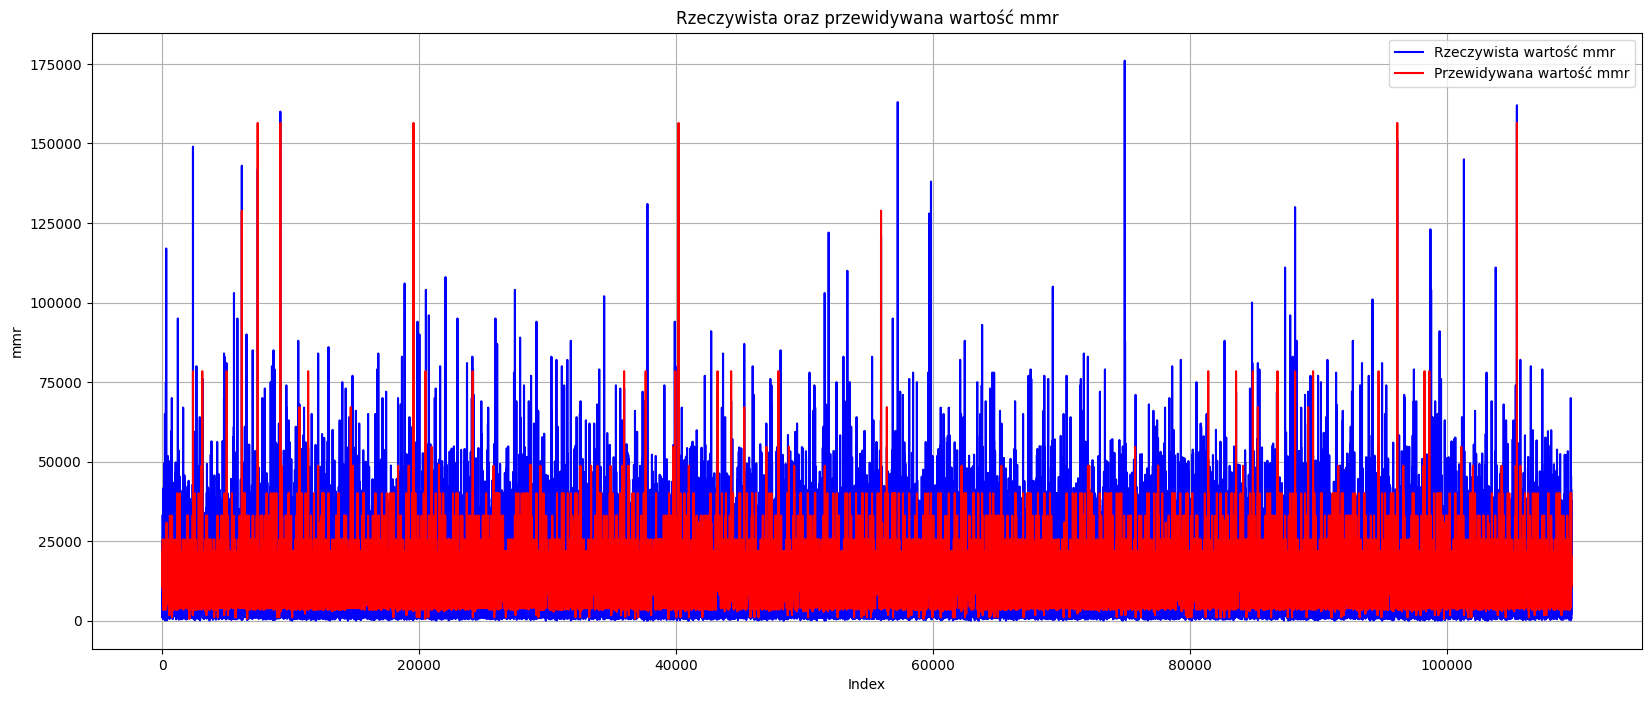

In [24]:
fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(y_test.values, label='Rzeczywista wartość mmr', color='blue', linestyle='-')
ax.plot(y_pred, label='Przewidywana wartość mmr', color='red', linestyle='-')

ax.legend()
ax.set_xlabel('Index')
ax.set_ylabel('mmr')
ax.set_title('Rzeczywista oraz przewidywana wartość mmr')
ax.grid()

plt.show()

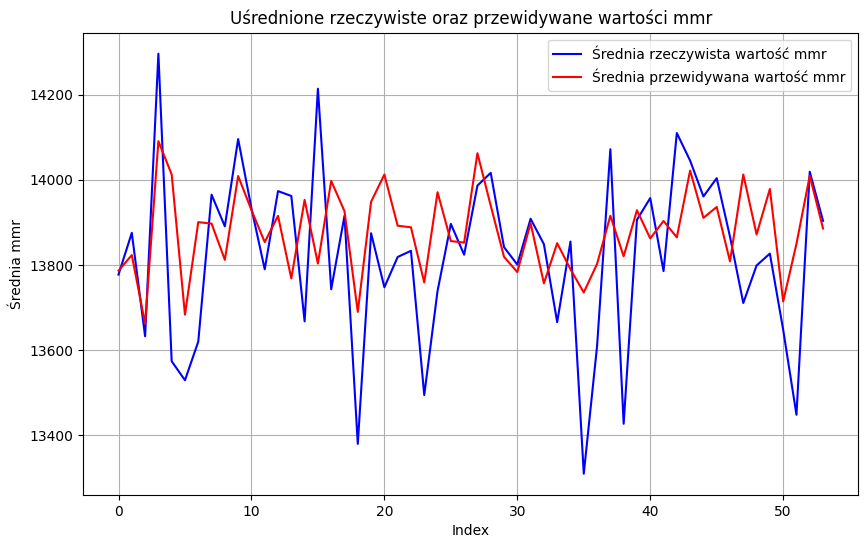

In [29]:
bins = np.arange(0, len(y_test) + 1, 2000)

y_test_binned_avg = [y_test.iloc[bins[i]:bins[i+1]].mean() for i in range(len(bins)-1)]
y_pred_binned_avg = [y_pred[bins[i]:bins[i+1]].mean() for i in range(len(bins)-1)]

plt.figure(figsize=(10, 6))

plt.plot(y_test_binned_avg, label='Średnia rzeczywista wartość mmr', color='blue')
plt.plot(y_pred_binned_avg, label='Średnia przewidywana wartość mmr', color='red')


plt.xlabel('Index')
plt.ylabel('Średnia mmr')
plt.title('Uśrednione rzeczywiste oraz przewidywane wartości mmr za pomocą drzew decyzyjnych')
plt.legend()
plt.grid()

plt.show()

In [30]:
from sklearn.svm import SVR

X = pd.get_dummies(data['make'])
y = data['mmr']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1410)

svr_model = SVR()
svr_model.fit(X_train, y_train)

y_pred = svr_model.predict(X_test)
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
y_test_avg = y_test.groupby(y_test.index // 10).mean()

In [ ]:
bins = np.arange(0, len(y_test) + 1, 2000)

y_test_binned_avg = [y_test.iloc[bins[i]:bins[i+1]].mean() for i in range(len(bins)-1)]
y_pred_binned_avg = [y_pred[bins[i]:bins[i+1]].mean() for i in range(len(bins)-1)]

plt.figure(figsize=(10, 6))

plt.plot(y_test_binned_avg, label='Średnia rzeczywista wartość mmr', color='blue')
plt.plot(y_pred_binned_avg, label='Średnia przewidywana wartość mmr', color='red')


plt.xlabel('Index')
plt.ylabel('Średnia mmr')
plt.title('Uśrednione rzeczywiste oraz przewidywane wartości mmr za pomocą SVR')
plt.legend()
plt.grid()

plt.show()